In [1]:
import pandas as pd
import sqlite3 as sq
import surprise

In [2]:
#Set up data
path = '/Users/Dustin/GT_project/test2.db'
def import_data(db_path):
    conn = sq.connect(db_path) #sqliteDB path goes in parantheses
    crsr = conn.cursor()

    df = pd.read_sql_query('''
                SELECT DISTINCT
                    customer_id,
                    product_id,
                    product_parent,
                    star_rating,
                    helpful_votes,
                    review_headline,
                    review_body,
                    product_category,
                    marketplace,
                    review_date,
                    verified_purchase
                FROM books
                WHERE LENGTH(STAR_RATING) < 2 and verified_purchase == 'Y'
                LIMIT 25000''', conn)

    df['star_rating'] = df['star_rating'].astype(float)
    df['star_rating'] = df['star_rating'].astype(int) #convert rating to integer type
    df['helpful_votes'] = df['helpful_votes'].astype(int) #convert rating to integer type

    df['review_body'] = df['review_body'].astype(str) #convert to str
    df['review_headline'] = df['review_headline'].astype(str) #convert to str
    

    return df

df = import_data(path)

In [3]:
df.head(1)
df.dtypes

customer_id           int64
product_id           object
product_parent        int64
star_rating           int64
helpful_votes         int64
review_headline      object
review_body          object
product_category     object
marketplace          object
review_date          object
verified_purchase    object
dtype: object

In [4]:
def count_words(data):
   words = data.split(" ")
   num_words = len(words)
   return num_words

df['review_word_count']=0
df['review_hl_count']=0

df['review_word_count'] = df['review_body'].map(count_words)
df['review_hl_count'] = df['review_headline'].map(count_words)


In [5]:
X_dat = df[['product_parent','star_rating','helpful_votes','review_word_count','review_hl_count']]

In [6]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X_dat)
visualizer.poof()

/anaconda3/lib/python3.6/site-packages/yellowbrick/features/rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()


<Figure size 800x550 with 2 Axes>

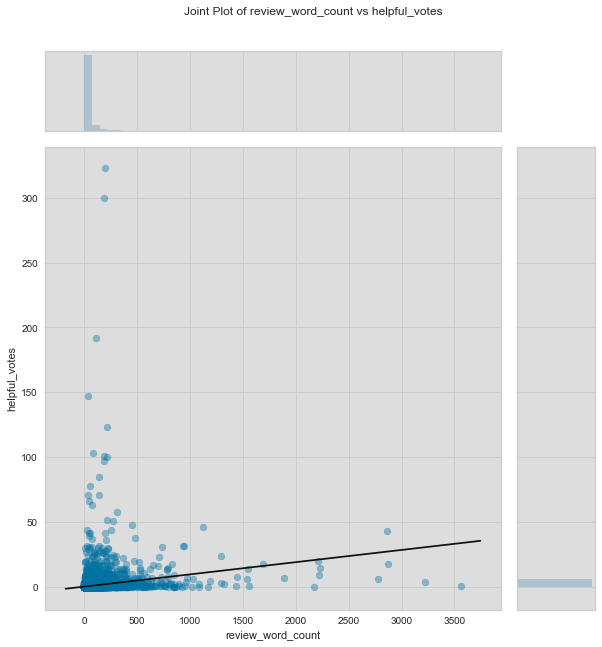

In [7]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='review_word_count', target='helpful_votes')
visualizer.fit(X_dat['review_word_count'], X_dat['helpful_votes'])
visualizer.poof()

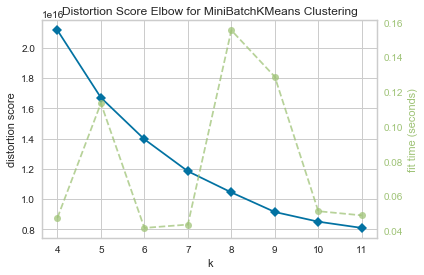

In [8]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(MiniBatchKMeans(), k=(4,12))

visualizer.fit(X_dat) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

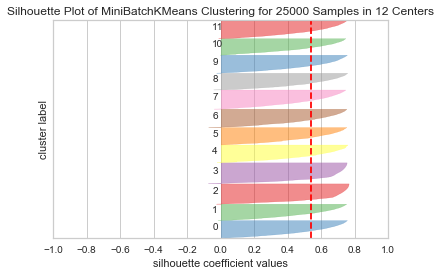

In [9]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans(12)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_dat) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [ ]:
from surprise import Reader, Dataset

# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib

ratings_dict = {'itemID': list(df.product_id),
                'userID': list(df.customer_id),
                'rating': list(df.star_rating)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)


In [ ]:


###Using Suprise package
# Split data into 5 folds

data.split(n_folds=5)

from surprise import SVD, evaluate
from surprise import NMF, model_selection

# svd
algo = SVD()
model_selection.cross_validate(algo, data, measures=['RMSE'])




In [ ]:
# nmf
algo = NMF()
nmf_mod = model_selection.cross_validate(algo, data, measures=['RMSE'])
nmf_mod.fit()